슝~


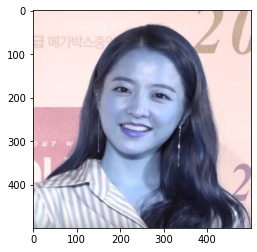

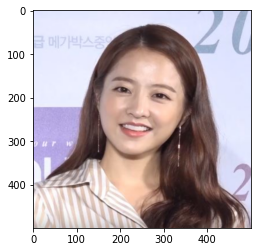

rectangles[[(159, 139) (345, 325)]]


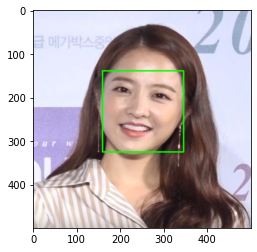

68


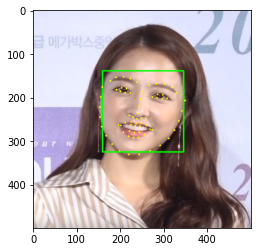

(240, 236)
(x,y) : (240,236)
(w,h) : (187,187)
(187, 187, 3)
(x,y) : (147,143)
(187, 187, 3)
(x,y) : (147,143)


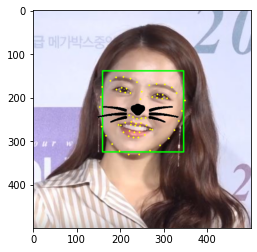

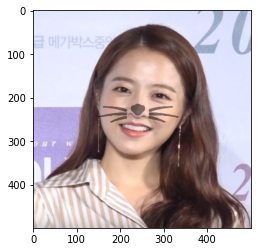

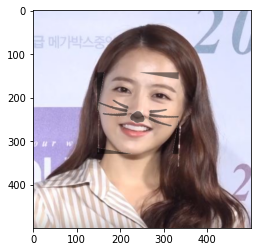

In [20]:
# 필요 라이브러리 import
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib
import math

print("슝~")

# opencv로 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (500, 500))    # 500x500의 크기로 Resize
img_bgr_orig = img_bgr.copy()
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

# opencv 는 RGB 대신 BGR 을 사용하기 때문에 RGB로 변경
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# HOG Detector 선언
detector_hog = dlib.get_frontal_face_detector()

# Bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

# 찾은 얼굴 영역 좌표
print(dlib_rects) # 찾는 얼굴 영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# landmark model 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # landmark 갯수 확인

# landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

# 스티커 이미지 Read
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
print (img_sticker.shape)

# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 불투명도 조절
sticker_area = img_bgr_orig[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# vector 계산
landmark = list_landmarks[0]
v1 = np.array([0, -1])
v2 = np.array([abs(landmark[33][0] - landmark[27][0]), abs(landmark[33][1] - landmark[27][1])])
unit_vector_1 = v1 / np.linalg.norm(v1)
unit_vector_2 = v2 / np.linalg.norm(v2)
dot_product = np.dot(unit_vector_1, unit_vector_2)
angle = np.arccos(dot_product)

# 회전 변환
rows, cols = img_sticker.shape[:2]
img_sticker_rot = cv2.warpAffine(img_sticker, cv2.getRotationMatrix2D((cols/2, rows/2), math.degrees(angle), 1), (cols, rows))
plt.imshow(img_sticker_rot)
plt.show

# 회전 후 불투명도 조절 -> 실패
sticker_area = img_bgr_orig[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker_rot==255,sticker_area,img_sticker_rot).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()